# Test de $\chi^2$ y cociente de verosimilitudes

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
from scipy.stats import rv_histogram

plt.rc("figure", dpi=120)
np.random.seed(42)


## Parametros

Se generan dos curvas:

1. lineal $y = b x$
2. parabola $y = a x^2 + b x$.

In [2]:
a = 0.03  # coeficiente cuadrático
b = 0.3  # coeficiente lineal

x = np.arange(-5, 6)
y_lineal = b * x
y_parabola = a * x ** 2 + b * x


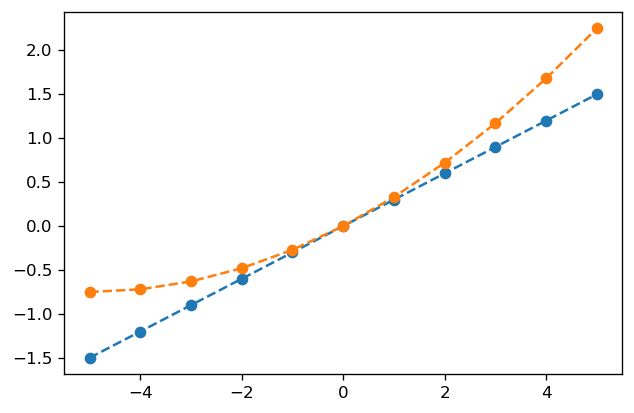

In [3]:
for y in (y_lineal, y_parabola):
    plt.plot(x, y, "o--")


Eligiendo la lineal como el modelo real, se toma una muestra para cada par $(x, y)$, donde $y$ tiene una distribución normal de ancho `sigma_y`:

In [4]:
sigma_y = 0.5  # desviación estandar

y_muestreo = np.random.normal(y_lineal, sigma_y)


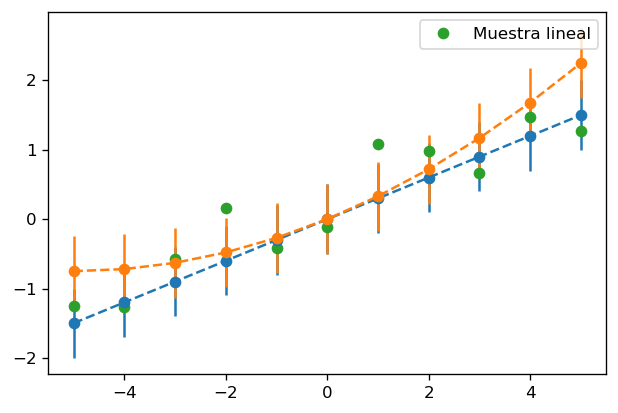

In [5]:
for y in (y_lineal, y_parabola):
    plt.errorbar(x, y, yerr=sigma_y, fmt="o--")

plt.plot(x, y_muestreo, "o", label="Muestra lineal")
plt.legend()


Se puede calcular el estadístico $\chi^2$ a partir de las distancias entre la muestra y el modelo:

In [6]:
def chi2(y_data, y_expected, sigma_y):
    distancia = y_data - y_expected
    return np.sum((distancia / sigma_y) ** 2)


chi2(y_muestreo, y_lineal, sigma_y)


6.927013008310444

Este también se puede calcular con el modelo incorrecto:

In [7]:
chi2(y_muestreo, y_parabola, sigma_y)


11.646374383975422

el cual *debería* dar un valor mayor.

Para repetir esto multiples veces, definimos una función que genera una muestra a partir de la hipotesis nula $H_0$ y devuelve el $\chi^2$ tanto para la hipotesis nula como una hipotesis alternativa $H_1$:

In [8]:
def sample_chi2(y_H0, y_H1, *, sigma_y):
    y = np.random.normal(y_H0, sigma_y)
    return {
        "H0": chi2(y, y_H0, sigma_y),
        "H1": chi2(y, y_H1, sigma_y),
    }


sample_chi2(y_lineal, y_parabola, sigma_y=sigma_y)


{'H0': 13.370389015876482, 'H1': 24.100301581437147}

Repitiendo esto múltiples veces, podemos estimar las distribuciones del estadístico $\chi^2$ bajo ambas hipótesis, y generando los datos con ambos modelos:

In [9]:
n = 10_000

df_lineal = [sample_chi2(y_lineal, y_parabola, sigma_y=sigma_y) for _ in range(n)]
df_lineal = pd.DataFrame(df_lineal)

df_parabola = [sample_chi2(y_parabola, y_lineal, sigma_y=sigma_y) for _ in range(n)]
df_parabola = pd.DataFrame(df_parabola)

df_lineal.head()


,H0,H1
0,8.048079,15.648671
1,9.651293,20.309548
2,9.408933,18.833845
3,8.147155,10.287743
4,14.050946,19.508117


### Poder del test

Para evaluar el poder del test, queremos comparar la distribución del estadístico comparando contra el mismo modelo (lineal) cuando la hipótesis nula es la correcta (`df_lineal.H0`) y cuando la hipótesis altenativa es la correcta, pero se comparó con el modelo incorrecto (`df_parabola.H1`).

<AxesSubplot:ylabel='Count'>

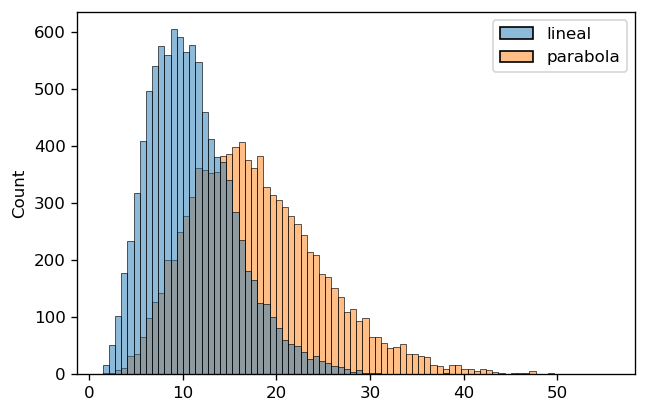

In [10]:
seaborn.histplot({"lineal": df_lineal.H0, "parabola": df_parabola.H1})

Para realizar calculos a partir de estos histogramas, vamos a construir una variable aleatoria con la función `scipy.stats.rv_histogram`:

In [11]:
H0_rv = rv_histogram(np.histogram(df_lineal.H0, bins="auto"))
H1_rv = rv_histogram(np.histogram(df_parabola.H1, bins="auto"))


Con este objeto, podemos realizar fácilmente cálculos a partir de la distribución. Por ejemplo, calcular el percentil 50 (la mediana):

In [12]:
H0_rv.ppf(0.5)


10.406577998576333

Eligiendo la probabilidad de falso negativo, o rechazar la hipótesis nula $H_0$ cuando está es verdadera, $\alpha = 5 \%$, podemos calcular el valor crítico del estadístico como el cuantil $1-\alpha$.

Con dicho valor crítico, podemos calcular la probabilidad de falso positivo, o no rechazar la hipótesis nula cuando esta es falsa, $\beta$, como la integral de $0$ hasta el valor crítico.

In [13]:
alpha = 0.05
threshold = H0_rv.ppf(1 - alpha)
beta = H1_rv.cdf(threshold)

print("threshold:", threshold)
print("     beta:", beta)

threshold: 19.607066493498802
     beta: 0.6372230049841474


Gráficamente, corresponden a las siguientes areas coloreadas de las distribuciones:

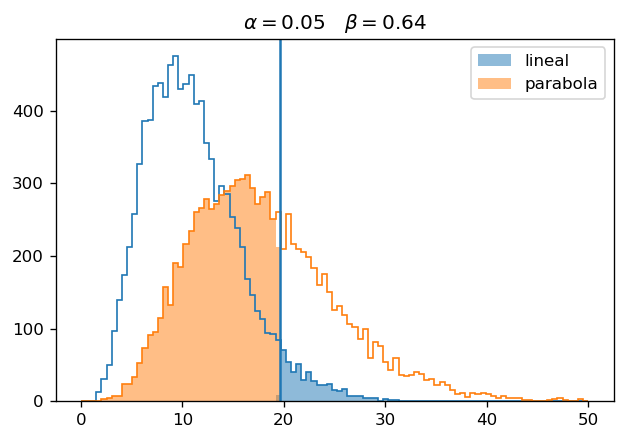

In [14]:
bins = np.linspace(0, 50, 100)

plt.hist(df_lineal.H0, bins=bins, histtype="step", color="C0")
plt.hist(
    df_lineal.H0[df_lineal.H0 > threshold],
    bins=bins,
    label="lineal",
    color="C0",
    alpha=0.5,
)

plt.hist(df_parabola.H1, bins=bins, histtype="step", color="C1")
plt.hist(
    df_parabola.H1[df_parabola.H1 < threshold],
    bins=bins,
    label="parabola",
    color="C1",
    alpha=0.5,
)

plt.axvline(threshold)
plt.title(f"$\\alpha = {alpha:.2f}$   $\\beta = {beta:.2f}$")
plt.legend()


### Curva ROC

La curva ROC nos permite evaluar el *trade-off* que hay entre rechazar la hipótesis nula $H_0$ cuando esta es correcta ($\alpha$), y aceptarla cuando la correcta era la hipótesis alternativa ($\beta$). La curva ROC grafica la probabilidad de tener un verdadero positivo ($1-\alpha$) y la probabilidad de tener un falso positivo ($\beta$).

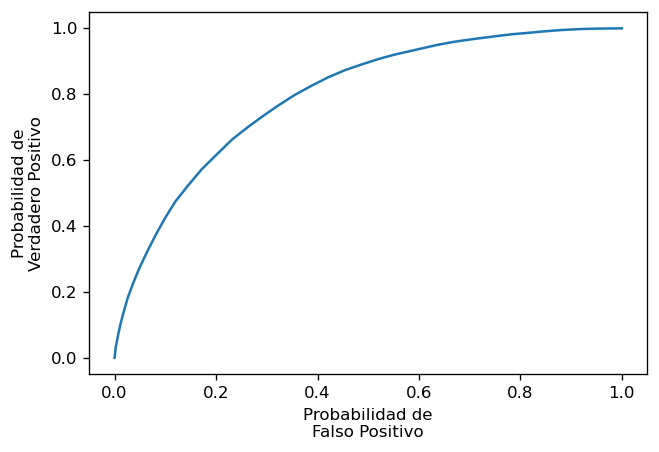

In [15]:
fig, ax = plt.subplots()
ax.set(
    xlabel="Probabilidad de\nFalso Positivo",
    ylabel="Probabilidad de\nVerdadero Positivo",
)

t = np.linspace(0, max(H0_rv.b, H1_rv.b), 100)
ax.plot(H1_rv.cdf(t), H0_rv.cdf(t))


## Likelihood-ratio test

Podemos mejorar la discriminación del test a través del *likelihood-ratio test*.

Para esto, tenemos que usar la otra distribución que no usamos hasta ahora: `df_lineal.H1`, el estadístico $\chi^2$ para datos generados a partir de la lineal, pero comparados con el modelo cuadrático.

Ya sea que calculemos el $\chi^2$ de datos generados a partir de una lineal contra una parábola o viceversa, terminamos con la misma distribución:

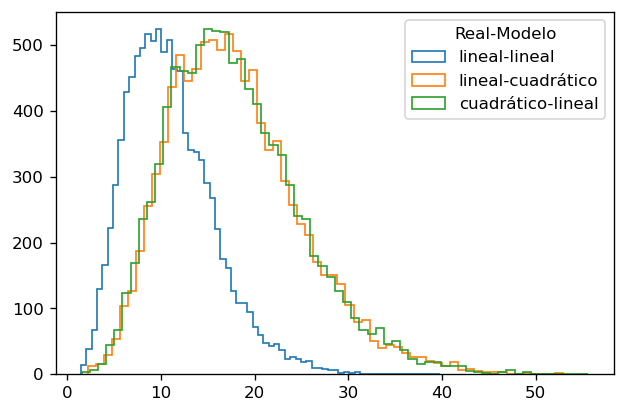

In [16]:
kwargs = dict(bins="auto", histtype="step")

plt.hist(df_lineal.H0, label="lineal-lineal", **kwargs)
plt.hist(df_lineal.H1, label="lineal-cuadrático", **kwargs)
plt.hist(df_parabola.H1, label="cuadrático-lineal", **kwargs)
plt.legend(title="Real-Modelo")

Pero para un mismo conjunto de datos $y$, el $\chi^2$ bajo la hipótesis nula y alternativa están correlacionados (ya que usan los mismos datos). Esto se puede ver al graficar la distribución conjunta en un *scatterplot*:

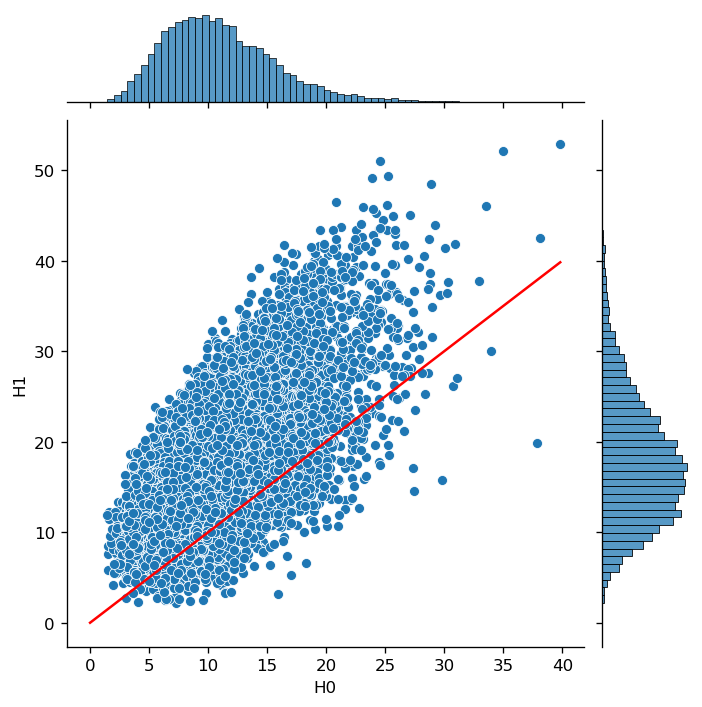

In [17]:
ax = seaborn.jointplot(x=df_lineal.H0, y=df_lineal.H1)
m = df_lineal.max().min()
ax.ax_joint.plot([0, m], [0, m], color="r")


Mientras que no sucede si comparamos los $\chi^2$ de tiras de datos distintas:

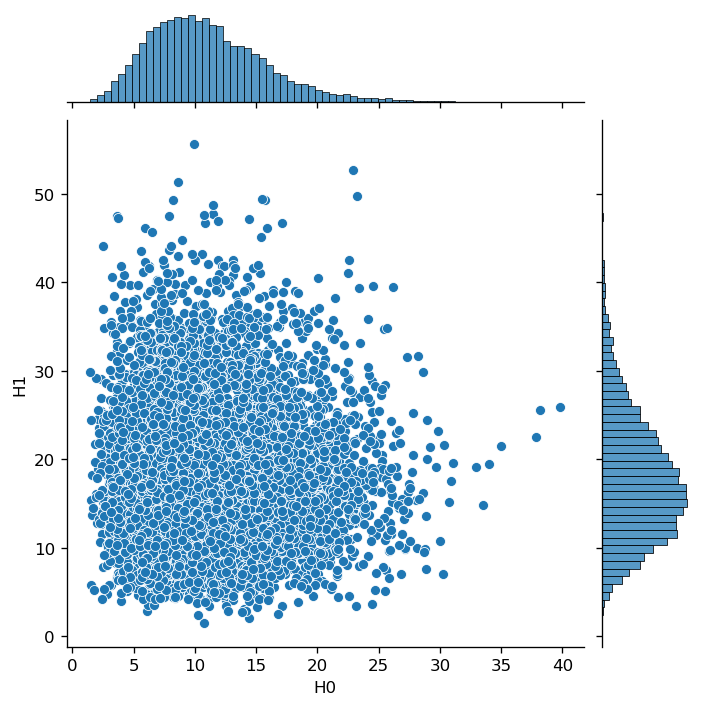

In [18]:
seaborn.jointplot(x=df_lineal.H0, y=df_parabola.H1)

El *likelihood-ratio test* aprovecha esta correlación para generar un estadístico mejor:

$$ Q = \frac{ \mathcal{L}(y \,|\, H_0) }{ \mathcal{L}(y \,|\, H_1) } $$

O, tomando el logaritmo y multiplicando por $-2$:

$$ \lambda = -2 \log{Q} = -2 \Big( \log{ \mathcal{L}(y \,|\, H_0) } - \log{ \mathcal{L}(y \,|\, H_1) } \Big) $$

En el caso de un *likelihood* gaussiano, se reduce a:

$$ \lambda = \Big( \chi^2(y \,|\, H_0) - \chi^2(y \,|\, H_1) \Big) $$

donde $\lambda = 0$ corresponde a la recta identidad en el *scatterplot* anterior (linea roja).

<AxesSubplot:ylabel='Count'>

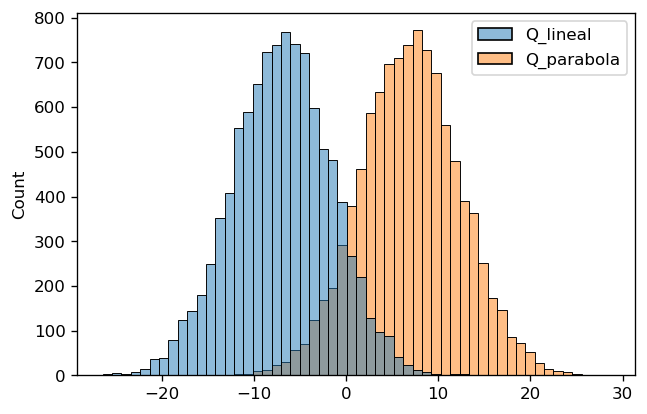

In [19]:
Q = pd.DataFrame(
    {
        "Q_lineal": df_lineal.H0 - df_lineal.H1,
        "Q_parabola": df_parabola.H1 - df_parabola.H0,
    }
)

seaborn.histplot(Q)


### Curva ROC

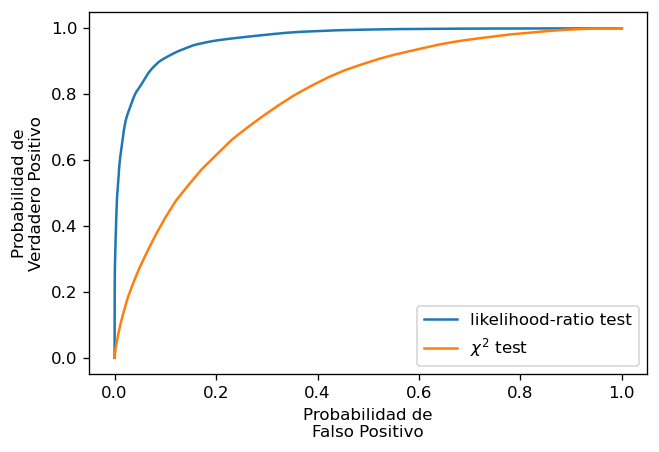

In [20]:
fig, ax = plt.subplots()
ax.set(
    xlabel="Probabilidad de\nFalso Positivo",
    ylabel="Probabilidad de\nVerdadero Positivo",
)

t = np.linspace(-100, 100, 1000)
ROC = Q.apply(np.histogram, bins=100).apply(rv_histogram).apply(lambda x: x.cdf(t))
ax.plot(ROC.Q_parabola, ROC.Q_lineal, label="likelihood-ratio test")

t = np.linspace(0, max(H0_rv.b, H1_rv.b), 100)
ax.plot(H1_rv.cdf(t), H0_rv.cdf(t), label="$\chi^2$ test")

ax.legend()
